In [261]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import numpy as np
import plotnine as p9
pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']


In [262]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [263]:
# LK = county_acronym
# LK-Nr = county_nr
# LK-Rev = fdist_nr
# fdist_id = fdist_id
# year = year
# timeframe = timeframe
# forest_ownership = forest_ownership
# infested_wood = infested_wood
# disposed_wood = disposed_wood

In [264]:
data.head()

,fdist_id,year,timeframe,forest_ownership,infested_wood,disposed_wood,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,endangered_forest_density,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,county_name,fdist_name,id,timestamp,prev_infested_wood,delta_prev_inf_dis,TX0_rollyr,TM0_rollyr,TN0_rollyr,RF0_rollyr,SD0_rollyr,RRU_rollyr,RRK_rollyr,FF1_rollyr,FF2_rollyr,FFB_rollyr,RGK_rollyr,ETP_rollyr,GRV_rollyr,KWU_rollyr,KWK_rollyr,prev_infested_wood_rollyr
0,2501,2007,06 Juni,SW,5.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,-37.537037,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-06-30,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0
1,2501,2007,06 Juni,NSW,0.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,-37.537037,Bautzen,Elsterheide,Bautzen-Elsterheide-NSW,2007-06-30,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0
2,2501,2007,08 August,SW,12.0,12.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.279797,18.506060,11.786532,70.830302,219.601339,48.208754,53.017506,2.509764,1.842424,2.053872,133.832676,96.605054,93.217507,-48.396294,-43.587545,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-08-31,0.0,0.0,16.594445,11.752413,6.483277,73.317564,251.263265,98.821490,110.180500,3.920791,2.880584,2.768547,132.720821,89.126204,93.345735,9.693434,21.054293,5.0
3,2501,2007,08 August,NSW,0.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.279797,18.506060,11.786532,70.830302,219.601339,48.208754,53.017506,2.509764,1.842424,2.053872,133.832676,96.605054,93.217507,-48.396294,-43.587545,Bautzen,Elsterheide,Bautzen-Elsterheide-NSW,2007-08-31,0.0,0.0,16.594445,11.752413,6.483277,73.317564,251.263265,98.821490,110.180500,3.920791,2.880584,2.768547,132.720821,89.126204,93.345735,9.693434,21.054293,0.0
4,2501,2007,10 Oktober-Dezember,SW,2.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,7.364197,4.503592,1.476655,84.804602,203.334004,123.481481,138.329965,3.765544,2.778900,2.672503,97.931986,61.908756,53.196970,61.572726,76.421211,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-12-31,0.0,0.0,15.056313,10.479714,5.505219,75.057996,225.076288,102.985604,114.807911,3.810802,2.803002,2.717733,126.898402,83.571015,85.808867,19.412738,31.236897,17.0


First, plot a map with the total number of newly damaged wood over the whole time period

To get a first impression of the data, we create a chloropleth map in which the total amount of obsereved infested wood (all observations) is shaded in for every forestry district. Since there is a different area of endangered forest (endangered = tree height above 20 metres as well as a spruce tree ratio of 10%) in every forestry district, we also overlay a bubble map where the bubble size represents the total area of endangered forest.

### History of infested wood obervations

In [265]:
import matplotlib.colors as mcolors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [266]:
# read shapefile with geodata since we need it to plot the map
# we only need the first 53 rows since these are the current districts
districts_gdf = gpd.read_file(r'forestry_districts.shp', encoding='utf-8').loc[:53]

districts_gdf.columns = ['county_name', 'fdist_name', 'fdist_id', 'area_nse', 'area_nsne', 
                         'area_se', 'area_sne', 'area_fdist', 'endangered_forest_density', 
                         'centroid_xcoord', 'centroid_ycoord', 'geometry']

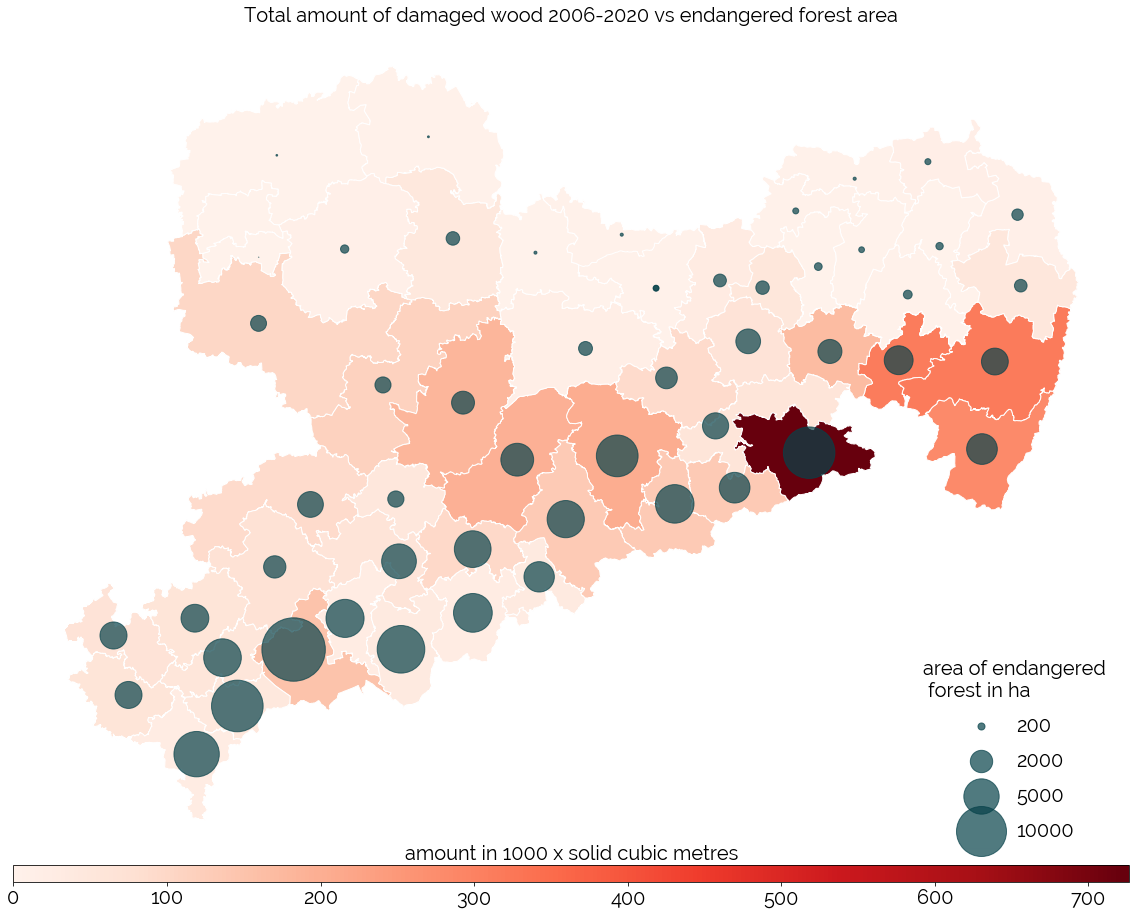

In [267]:
# get the total amount of damaged wood for every forestry district
total_infested_wood = data.groupby('fdist_name')['infested_wood'].sum()

# map information on total amount of damaged wood from dataset to the geodataframe entries
districts_gdf['total_infested_wood'] = [total_infested_wood.loc[total_infested_wood.index == district_name].item()/1000 for district_name in districts_gdf['fdist_name']]

# create column with total amount of endangered forest area (add private and state owned together)
# scale by 0.25 to get the right bubble sizes, later scale the same amount in legend
area_scale = .25
districts_gdf['area_endangered'] = (districts_gdf['area_nse'] + districts_gdf['area_se']) * area_scale


# create plot
fig, ax = plt.subplots(figsize=(20,20))

# plot title
plt.title('Total amount of damaged wood 2006-2020 vs endangered forest area', fontdict={'fontsize': 20})

# custom legend for colormap requires locateable axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0.1) # colormap parameters

# plot the forestry districts chloropleth map

districts_gdf.plot(ax=ax, column='total_infested_wood', legend=True, cax=cax,
          edgecolor='white', linewidth=1, legend_kwds={'orientation': 'horizontal'},
          cmap=truncate_colormap(plt.get_cmap('Reds'), 0.02, 1))


# colormap legend title and ticks
plt.title('amount in 1000 x solid cubic metres', fontdict={'fontsize': 20})
cax.tick_params(labelsize=20)


#counties_gdf = districts_gdf.dissolve(by='KREIS_NAME')
#counties_gdf.plot(ax=ax, legend=True, color='none',
#                edgecolor='black', linewidth=.5)

# bubble map 
# calculate representative points from polygons (used as bubble location)
gdf_points = districts_gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].representative_point()
# plot bubbles
gdf_points.plot(ax=ax, color='#07424A', markersize='area_endangered', alpha=.7, categorical=False, legend=True)

# make some dummy points at 0,0 to use as custom legend handles in the bubble plot legend
ax.scatter([0], [0], c='#07424A', alpha=.7, s=200*area_scale,
            label='200')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=2000*area_scale,
            label='2000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=5000*area_scale,
            label='5000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=10000*area_scale,
            label='10000')

# add bubble map legend
ax.legend(scatterpoints=1, frameon=True,
        labelspacing=.8, loc='lower right', fontsize=20, edgecolor='white',
        bbox_to_anchor=(1,0), title_fontsize=20, title='area of endangered \n forest in ha');

# x and y axis settings
ax.set_xlim(267100.4013500002, 514160.39804999967);
ax.set_ylim(5552730.938154999, 5736554.970745001);
ax.axis('off');


We can also print out th top and bottom values to supplement the plot:

In [268]:
# first restore the original amount of damaged wood and endangered forest area (revert scale)
districts_gdf['area_endangered'] = districts_gdf['area_endangered']/area_scale
districts_gdf['total_infested_wood'] = districts_gdf['total_infested_wood']*1000

# get top and bottom rows regarding amount of damaged wood
district_info = districts_gdf[['county_name', 'fdist_name', 'total_infested_wood', 'area_endangered']].sort_values('total_infested_wood', ascending=False)
district_info.head(4).append(district_info.tail(4))

,county_name,fdist_name,total_infested_wood,area_endangered
38,Sächsische Schweiz-Osterzgebirge,Sebnitz,726589.19,10611.80
42,Görlitz,Löbau,317423.00,2879.04
20,Bautzen,Cunewalde,314677.26,3332.18
19,Görlitz,Zittau,283009.66,3772.59
6,Nordsachsen,Delitzsch,313.14,11.40
14,Meißen,M West,70.00,36.16
48,Kreisfreie Stadt Leipzig,Connewitz,0.00,0.54
49,Kreisfreie Stadt Leipzig,Leutzsch,0.00,0.00


The first thing that catches the eye is the dark red shade of the *Sebnitz* district. The amount of total observed damaged wood far exceeds that of the other forestry districts. Some correlation exists between the amount of damaged wood and the area of endangered forest. However there are also other factors at play. Although the area of endangered forest of the forestry districts of the *Görlitz* county in the east and the *Erzgebirgskreis* in the central south are comparable, *Görlitz* has much higher amounts of damaged wood.

Let's take a closer look at relationship between area of endangered forest and amount of damaged wood. 

In [33]:
newcounty = data['county_name']*(data['infested_wood']*100).astype(int)

In [164]:
newdata = data[['county_name','district_name','forest_ownership', 'infested_wood']]

In [165]:
new_df = newdata.loc[newdata.index.repeat((newdata['infested_wood']*1).astype(int))]

In [166]:
new_df.shape

(4495810, 4)

In [181]:
from pysankey2 import Sankey
from pysankey2.utils import setColorConf

s = Sankey(new_df[['county_name','district_name','forest_ownership']], stripColor='left', colorMode='layer')


In [70]:
fig, ax= s.plot(stripLen=10, figSize=(30,20), fontPos=(0.9,0.5), text_kws={'family':'sans-serif'})

NameError: name 's' is not defined

In [71]:
from pysankey import sankey

sankey.sankey(
    left=data['county_name'], right=data['district_name'], leftWeight=data['infested_wood'], aspect=10,
    fontsize=15
)
plt.gcf().set_size_inches(20,20)

ModuleNotFoundError: No module named 'pysankey'

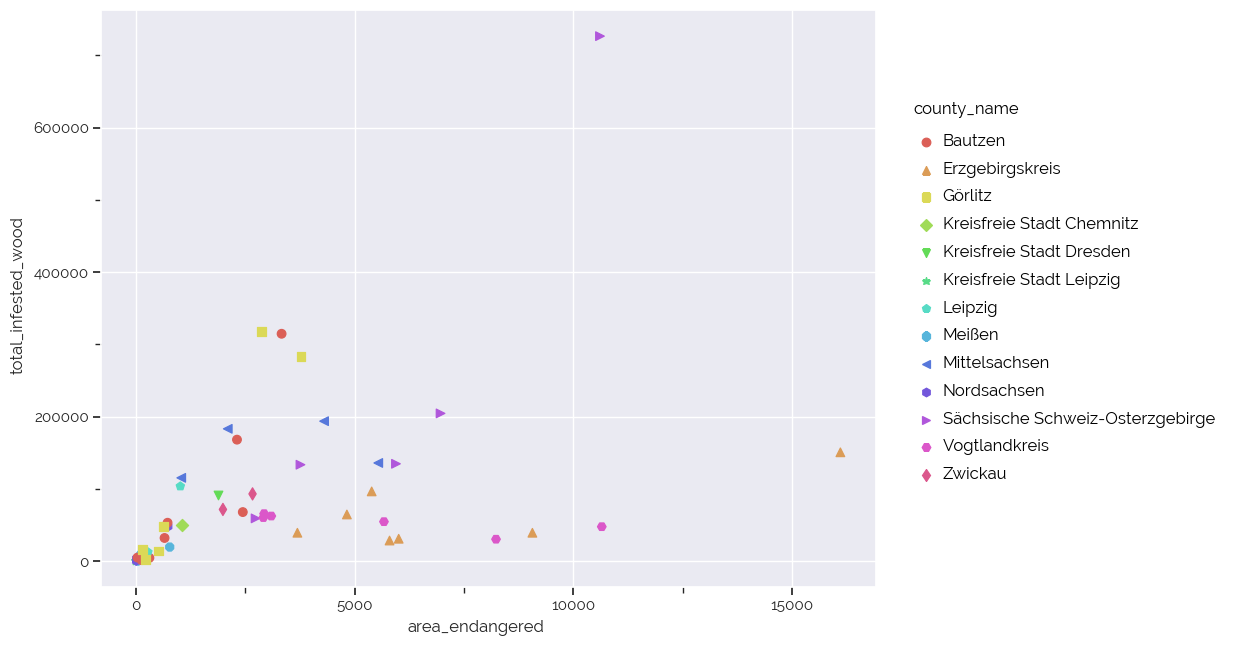

In [188]:
p9.options.figure_size = (10, 7.5)

(
    p9.ggplot(districts_gdf, p9.aes('area_endangered' , 'total_infested_wood', color='county_name')) 
    + p9.geom_point(p9.aes(shape='county_name'), size=3)
    + p9.theme_seaborn()
).draw();

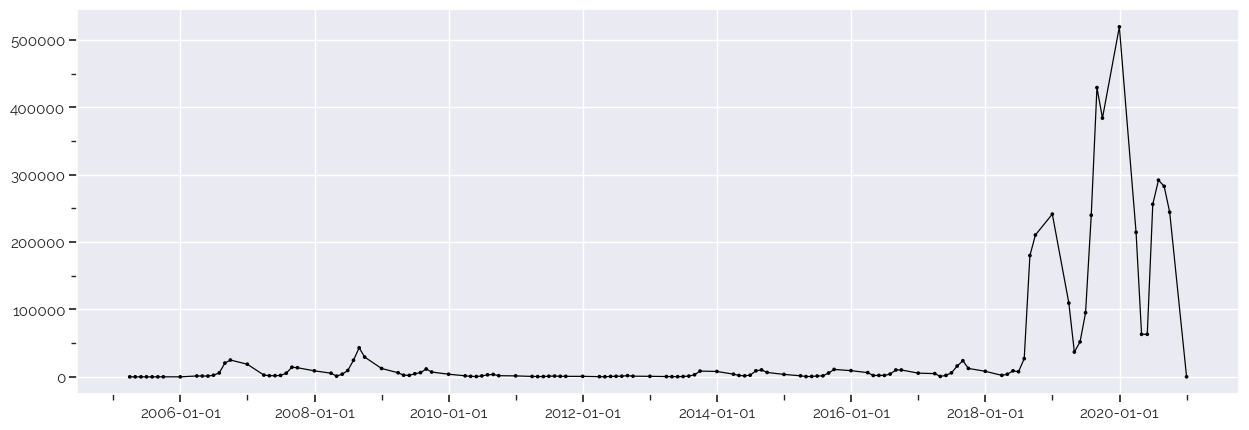

In [6]:
p9.options.figure_size = (15, 5)
(
    p9.ggplot(p9.aes(data.groupby('timestamp')['infested_wood'].sum().index, data.groupby('timestamp')['infested_wood'].sum().values)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + p9.theme_seaborn()
).draw();

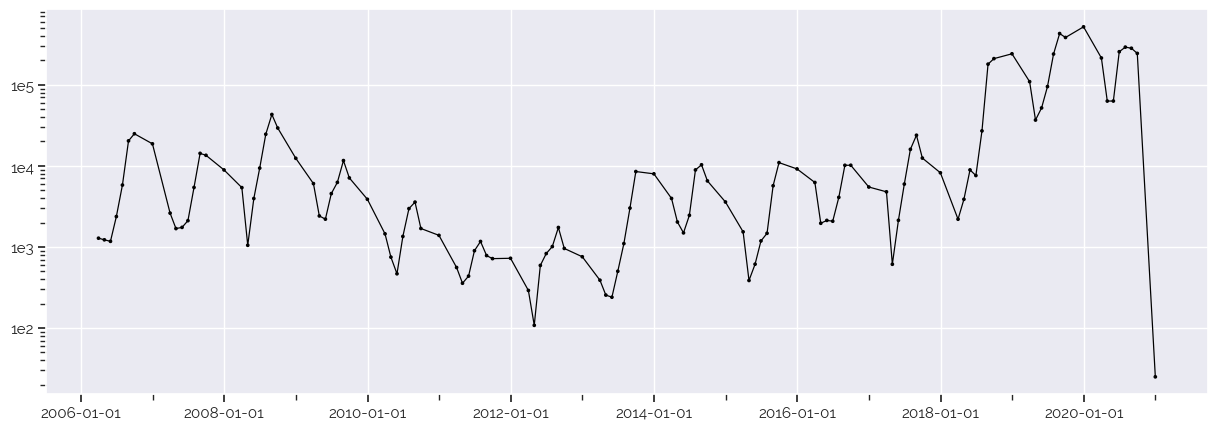

In [52]:
(
    p9.ggplot(p9.aes(x,y)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + p9.scale_y_log10()
    + p9.theme_seaborn()
).draw();

In [76]:
grouped_by_county = data.groupby(['timestamp','county_name'])['infested_wood'].sum().reset_index()

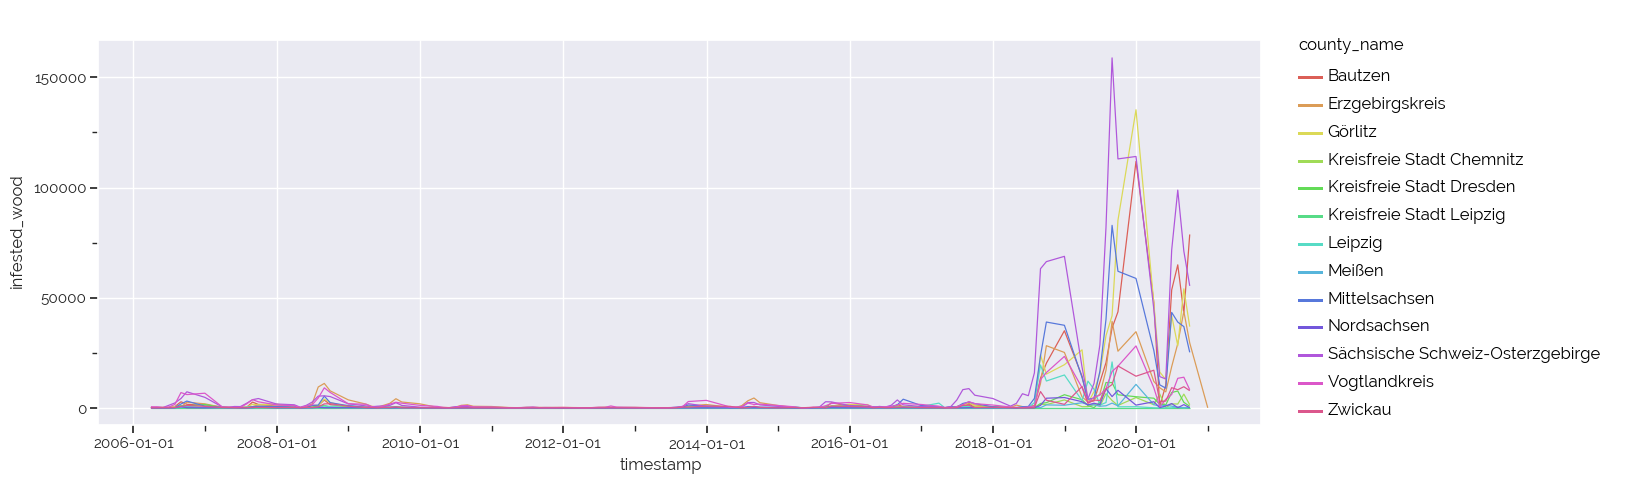

In [56]:
(
    p9.ggplot(grouped_by_county, p9.aes('timestamp', 'infested_wood', color='county_name'))
    + p9.geom_line()
    + p9.theme_seaborn()
).draw();

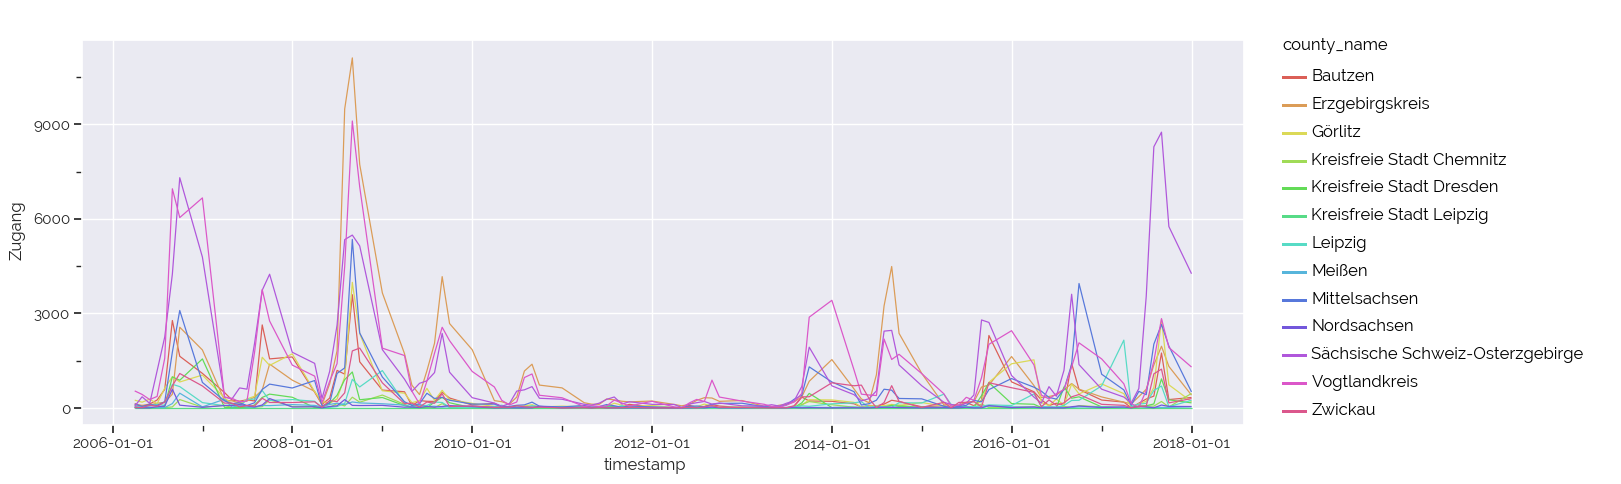

In [62]:
(
    p9.ggplot(grouped_by_county[grouped_by_county['timestamp'] < pd.Timestamp('2018-01-01')], p9.aes('timestamp', 'infested_wood', color='county_name')) 
    + p9.geom_line()
    + p9.theme_seaborn()
).draw();

In [29]:
data.head()

,fdist_id,year,timeframe,forest_ownership,infested_wood,disposed_wood,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,county_name,fdist_name,id,timestamp,prev_infested_wood,delta_prev_inf_dis,TX0_rollyr,TM0_rollyr,TN0_rollyr,RF0_rollyr,SD0_rollyr,RRU_rollyr,RRK_rollyr,FF1_rollyr,FF2_rollyr,FFB_rollyr,RGK_rollyr,ETP_rollyr,GRV_rollyr,KWU_rollyr,KWK_rollyr,prev_infested_wood_rollyr,endangered_forest_density
0,2501,2007,06 Juni,SW,5.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,-37.537037,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-06-30,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0,16.169175
1,2501,2007,06 Juni,NSW,0.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,-37.537037,Bautzen,Elsterheide,Bautzen-Elsterheide-NSW,2007-06-30,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0,16.169175
2,2501,2007,08 August,SW,12.0,12.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,24.279797,18.506060,11.786532,70.830302,219.601339,48.208754,53.017506,2.509764,1.842424,2.053872,133.832676,96.605054,93.217507,-48.396294,-43.587545,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-08-31,0.0,0.0,16.594445,11.752413,6.483277,73.317564,251.263265,98.821490,110.180500,3.920791,2.880584,2.768547,132.720821,89.126204,93.345735,9.693434,21.054293,5.0,16.169175
3,2501,2007,08 August,NSW,0.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,24.279797,18.506060,11.786532,70.830302,219.601339,48.208754,53.017506,2.509764,1.842424,2.053872,133.832676,96.605054,93.217507,-48.396294,-43.587545,Bautzen,Elsterheide,Bautzen-Elsterheide-NSW,2007-08-31,0.0,0.0,16.594445,11.752413,6.483277,73.317564,251.263265,98.821490,110.180500,3.920791,2.880584,2.768547,132.720821,89.126204,93.345735,9.693434,21.054293,0.0,16.169175
4,2501,2007,10 Oktober-Dezember,SW,2.0,0.0,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,7.364197,4.503592,1.476655,84.804602,203.334004,123.481481,138.329965,3.765544,2.778900,2.672503,97.931986,61.908756,53.196970,61.572726,76.421211,Bautzen,Elsterheide,Bautzen-Elsterheide-SW,2007-12-31,0.0,0.0,15.056313,10.479714,5.505219,75.057996,225.076288,102.985604,114.807911,3.810802,2.803002,2.717733,126.898402,83.571015,85.808867,19.412738,31.236897,17.0,16.169175


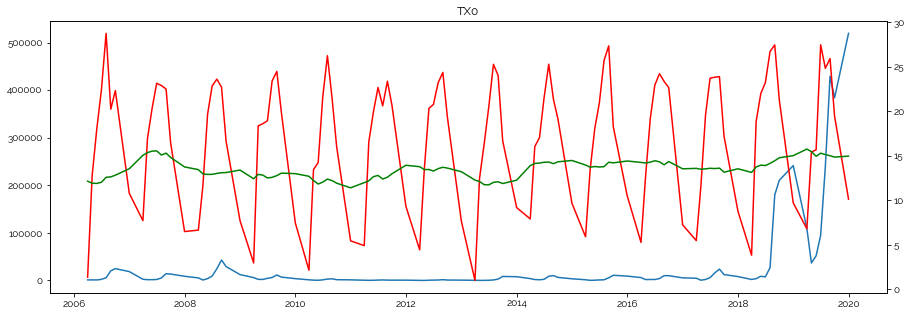

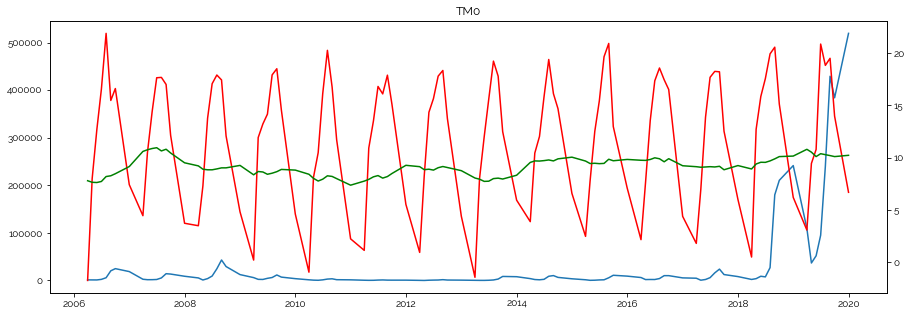

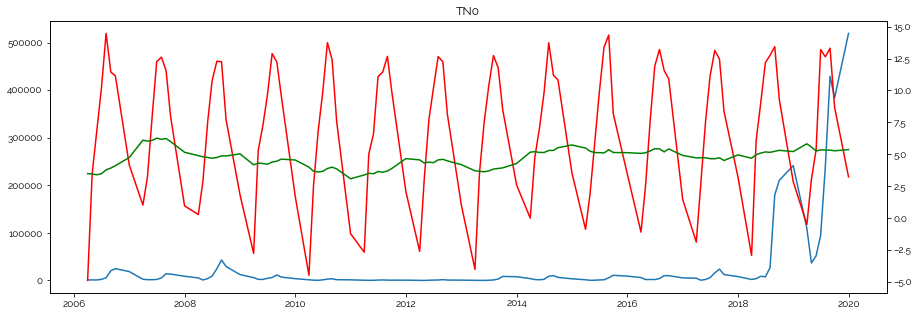

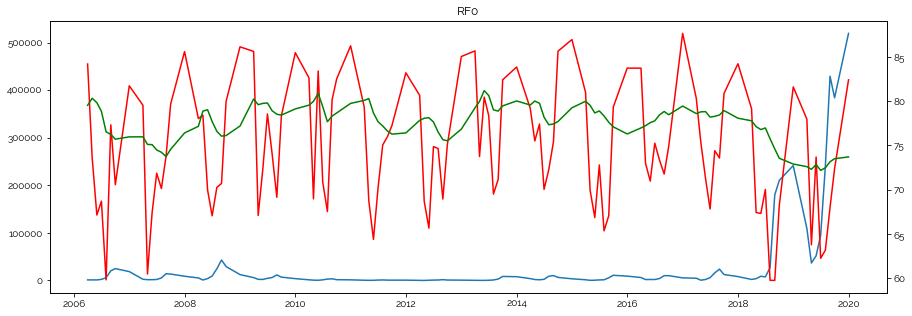

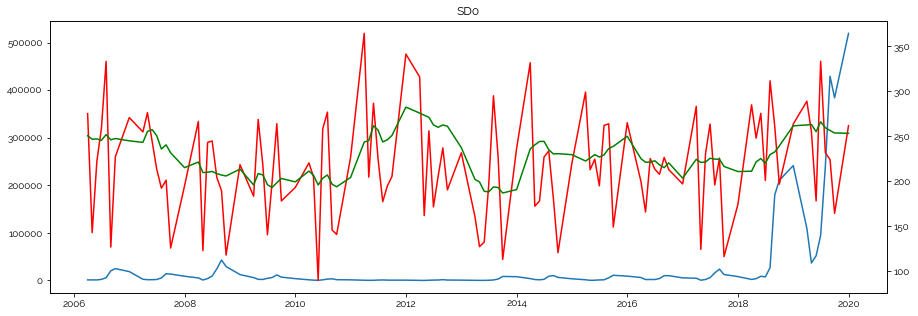

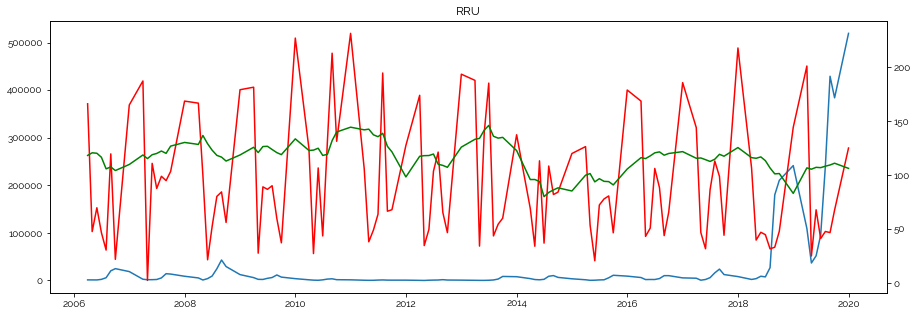

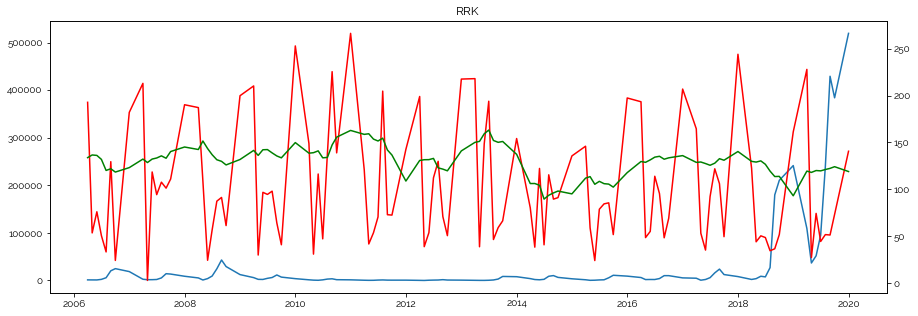

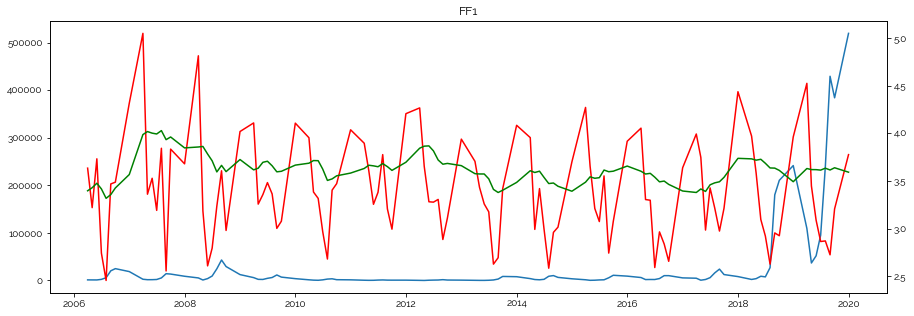

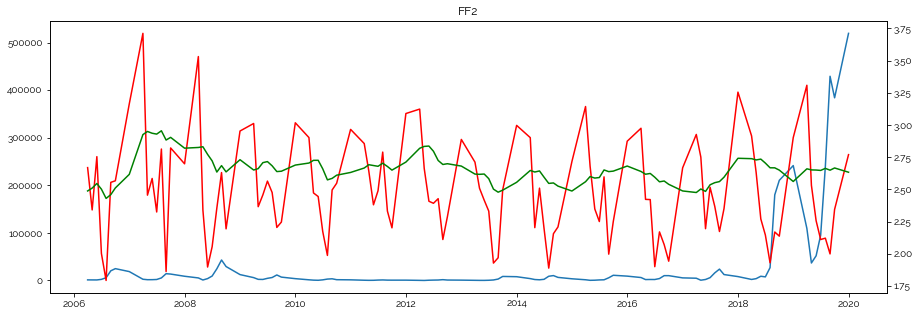

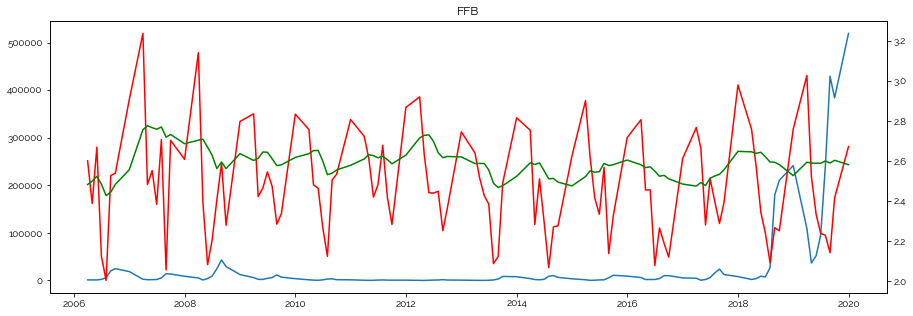

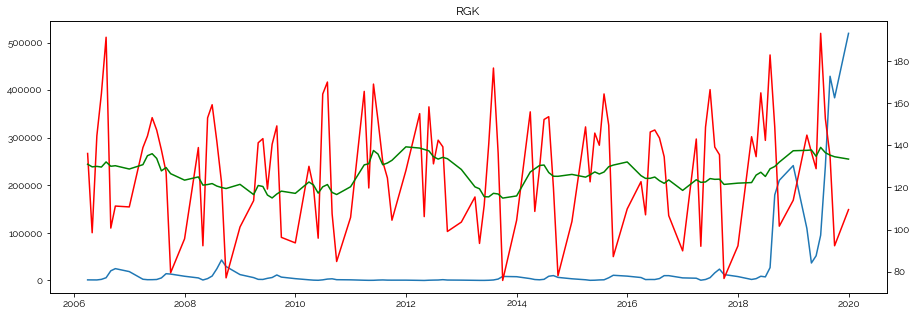

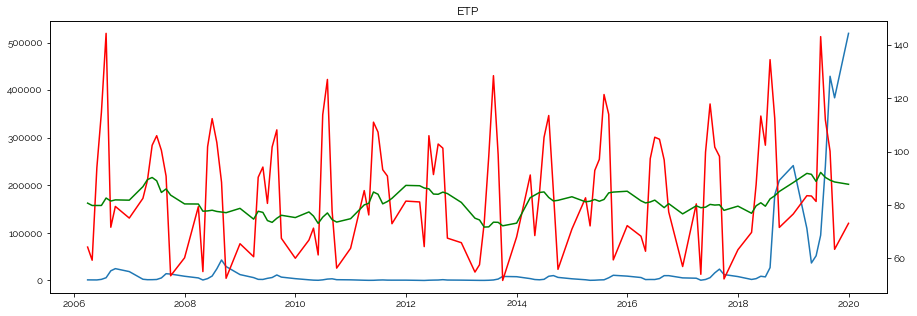

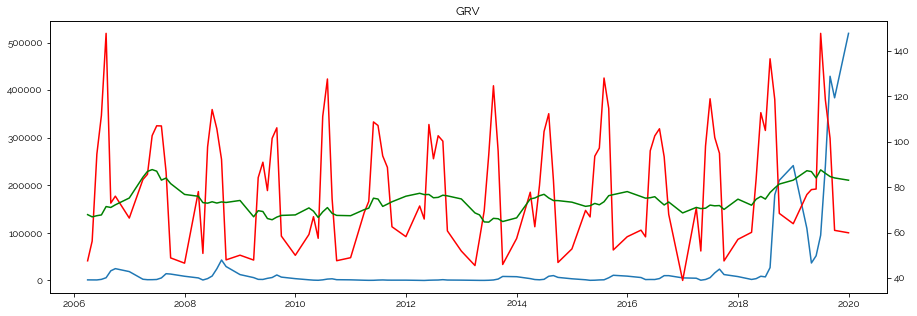

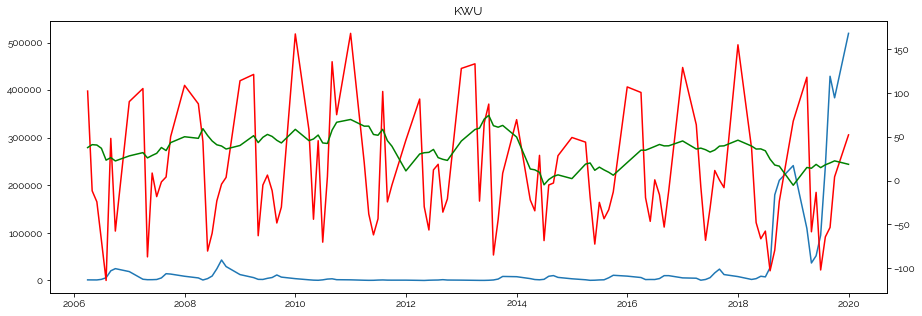

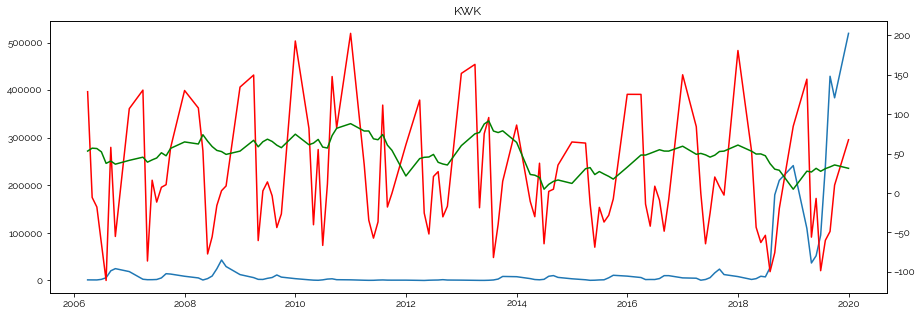

In [47]:
parameter_info = [
    'TX0', # maximum temperature of the day in degrees Celsius
    'TM0', # mean temperature of the day in degrees Celsius
    'TN0', # minimum temperature of the day in degrees Celsius
    'RF0', # mean relative humidity of the day in %
    'SD0', # total sunshine duration of the day in h
    'RRU', # total precipitation of the day in mm
    'RRK', # corrected total precipitation of the day in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
    'FF1', # mean wind velocity of the day 10 metres above ground in m*s-1
    'FF2', # mean wind velocity of the day 2 metres above ground in m*s-1
    'FFB', # wind speed of the day on the beaufort scale in bft
    'RGK', # total global solar irradiation of the day in kWh*m-2
    'ETP', # potential evaporation for the day in mm
    'GRV', # potential evapotranspiration for the day in mm
    'KWU', # 
    'KWK' # 
]

relevant = data[(data['timestamp'] <= pd.to_datetime('2020-03-01')) & (data['timestamp'] >= pd.to_datetime('2006-01-01'))]

for param in parameter_info:
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title(param)
    ax = plt.gca()
    ax.plot(relevant.groupby('timestamp')['infested_wood'].sum().index, relevant.groupby('timestamp')['infested_wood'].sum().values)
    ax2 = ax.twinx()
    ax2.plot(relevant.groupby('timestamp')[param].mean().index, relevant.groupby('timestamp')[param].mean().values, color='red')
    ax2.plot(relevant.groupby('timestamp')[param+'_rollyr'].mean().index, relevant.groupby('timestamp')[param+'_rollyr'].mean().values, color='green')
    #ax2.set_ylim(-30000,100000)
    plt.show();

In [384]:
x_labels = [v for v in sorted(corr['x'].unique())]
[p[0] for p in enumerate(x_labels)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [460]:
corr['value'].unique()


array([ 1.        ,  0.99578073,  0.96745956, -0.71753487,  0.0075317 ,
       -0.56561853, -0.59938845, -0.62235379, -0.62229739, -0.62032633,
        0.40317404,  0.70520557,  0.76329911, -0.70188736, -0.71846126,
        0.98557272, -0.67211659, -0.02146172, -0.51844755, -0.55386866,
       -0.60256043, -0.6023069 , -0.60058116,  0.37527708,  0.69211326,
        0.75087032, -0.6574862 , -0.67524305, -0.56575209, -0.09092363,
       -0.42919036, -0.46673118, -0.5596174 , -0.55929253, -0.55917316,
        0.29242355,  0.63188865,  0.69026358, -0.56250974, -0.58265182,
       -0.31621174,  0.69792664,  0.70900829,  0.4350748 ,  0.43675888,
        0.42483388, -0.61944657, -0.71404683, -0.79037034,  0.81780808,
        0.81618424, -0.03079171, -0.01670556,  0.04160197,  0.04141879,
        0.0379916 ,  0.75833639,  0.60374743,  0.47948705, -0.2130111 ,
       -0.18384414,  0.99818458,  0.51184419,  0.51383428,  0.49766782,
       -0.22373091, -0.32635256, -0.39123443,  0.95634152,  0.95

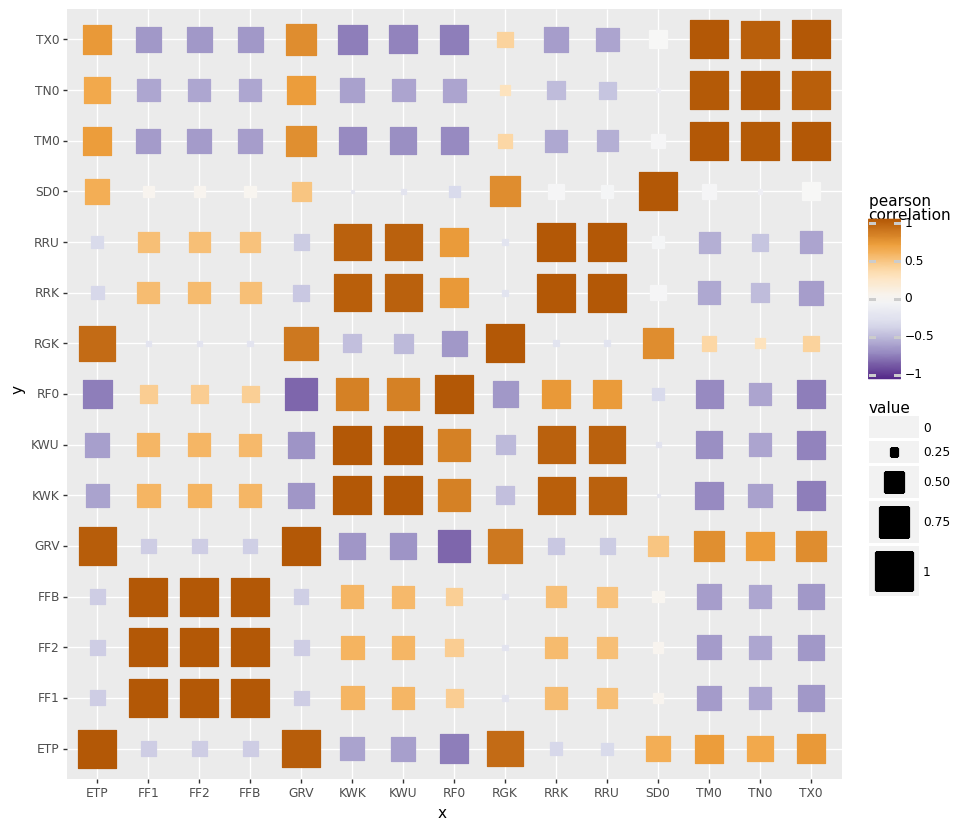

In [465]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, size, color):
    p9.options.figure_size = (10,10)
    # Mapping from column names to integer coordinates
    x_to_num = [p[0] for p in enumerate(x)]
    y_to_num = [p[0] for p in enumerate(y)]

    
    #color
    size_scale = 500

    
    (p9.ggplot(p9.aes(x,y, size=size, color=color, group=1))
    + p9.geom_point(shape='s'#, position=p9.position_nudge(x=-0.5, y=-0.5)
                   )
    + p9.scales.scale_color_distiller(
        type='div',
        name='pearson \ncorrelation', 
        limits=[-1,1],
        palette=4)
     + p9.scales.scale_size_continuous(range=[-10,15], limits=[0,1])
     #+ p9.scales.scale_x_continous()
     #+ p9.scale_y_discrete(expand=(0, 0, 0, 0))
     + p9.theme()
     #+ p9.ylim(-1,16)
     #+ p9.theme_matplotlib()
    ).draw();
    
    # Show column labels on the axes
    #ax.set_xticks([x_to_num[v] for v in x_labels])
    #ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    #ax.set_yticks([y_to_num[v] for v in y_labels])
    #ax.set_yticklabels(y_labels)
    

columns = [
    'TX0', # maximum temperature of the day in degrees Celsius
    'TM0', # mean temperature of the day in degrees Celsius
    'TN0', # minimum temperature of the day in degrees Celsius
    'RF0', # mean relative humidity of the day in %
    'SD0', # total sunshine duration of the day in h
    'RRU', # total precipitation of the day in mm
    'RRK', # corrected total precipitation of the day in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
    'FF1', # mean wind velocity of the day 10 metres above ground in m*s-1
    'FF2', # mean wind velocity of the day 2 metres above ground in m*s-1
    'FFB', # wind speed of the day on the beaufort scale in bft
    'RGK', # total global solar irradiation of the day in kWh*m-2
    'ETP', # potential evaporation for the day in mm
    'GRV', # potential evapotranspiration for the day in mm
    'KWU', # 
    'KWK' # 
]
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)

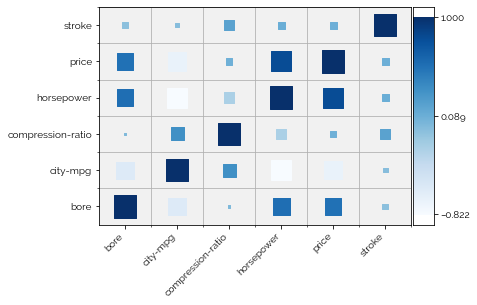

In [259]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['bore', 'stroke', 'compression-ratio', 'horsepower', 'city-mpg', 'price'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

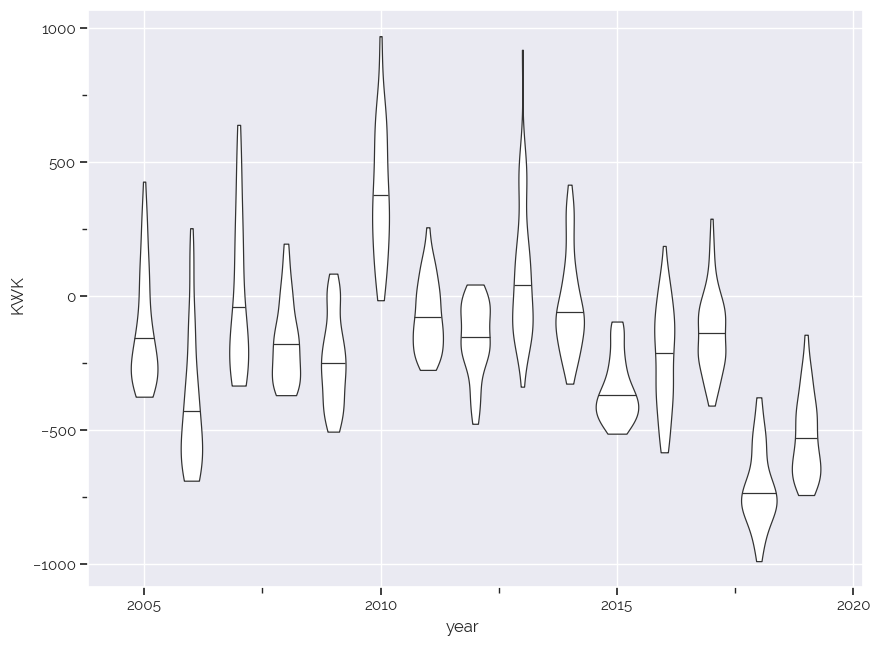

In [140]:
draw = data[(data['year'].isin(range(2005,2020))) & data['timestamp'].map(lambda x: x.month).isin(range(4,10))].copy()

draw['KWK'] = draw.groupby(['fdist_name', 'year'])['KWK'].transform('sum').copy()

draw.drop_duplicates(['year', 'fdist_name'], inplace=True)

(p9.ggplot(p9.aes('year', 'KWK', group='year'), data=draw)
    + p9.geom_violin(draw_quantiles=(0.5))
    + p9.theme_seaborn()).draw();

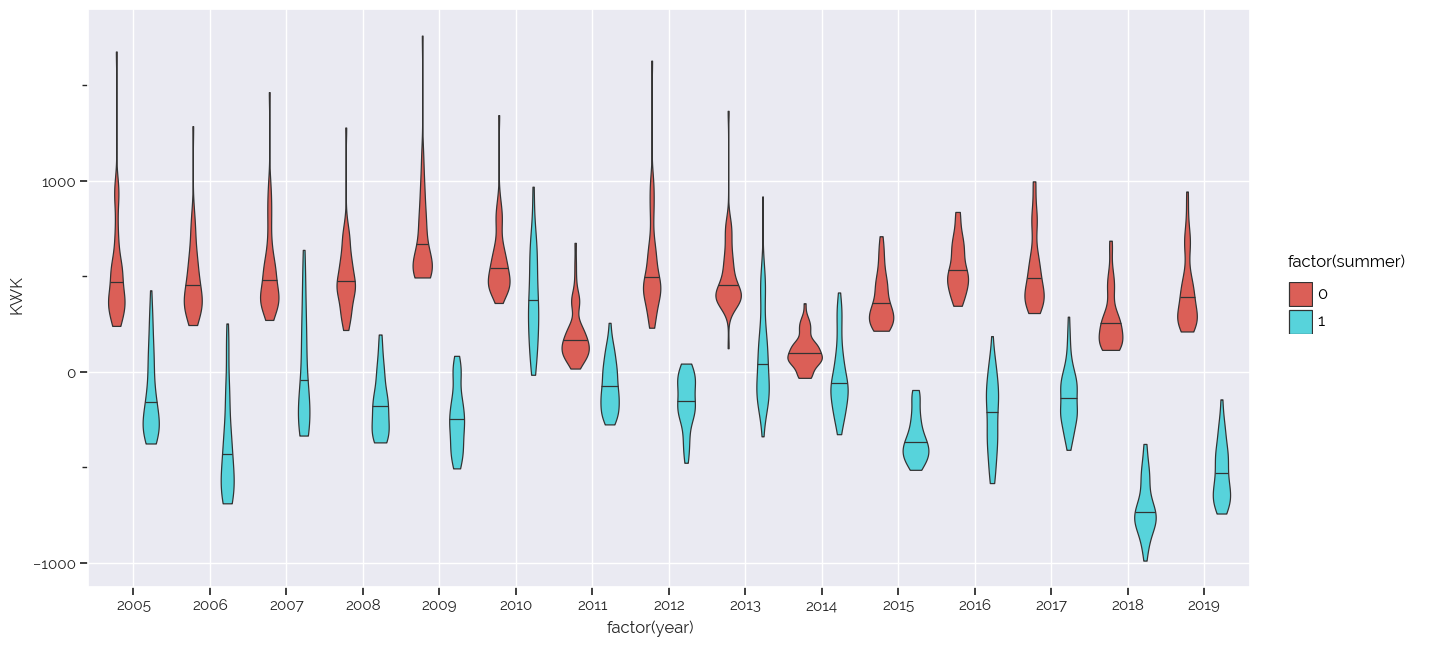

In [173]:
p9.options.figure_size = (15, 7.5)

draw = data[data['year'].isin(range(2005,2020))].copy()
draw['summer'] = draw['timestamp'].map(lambda x: 1 if x.month in range(4,10) else 0)
draw['KWK'] = draw.groupby(['fdist_name', 'summer', 'year'])['KWK'].transform('sum').copy()
draw.drop_duplicates(['year', 'summer', 'fdist_name'], inplace=True)

(p9.ggplot(draw, p9.aes('factor(year)', 'KWK', fill='factor(summer)'))
 + p9.geom_violin(draw_quantiles=(0.5))
 + p9.theme_seaborn()
).draw();

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_boxplot : Removed 667 rows containing non-finite values.


1


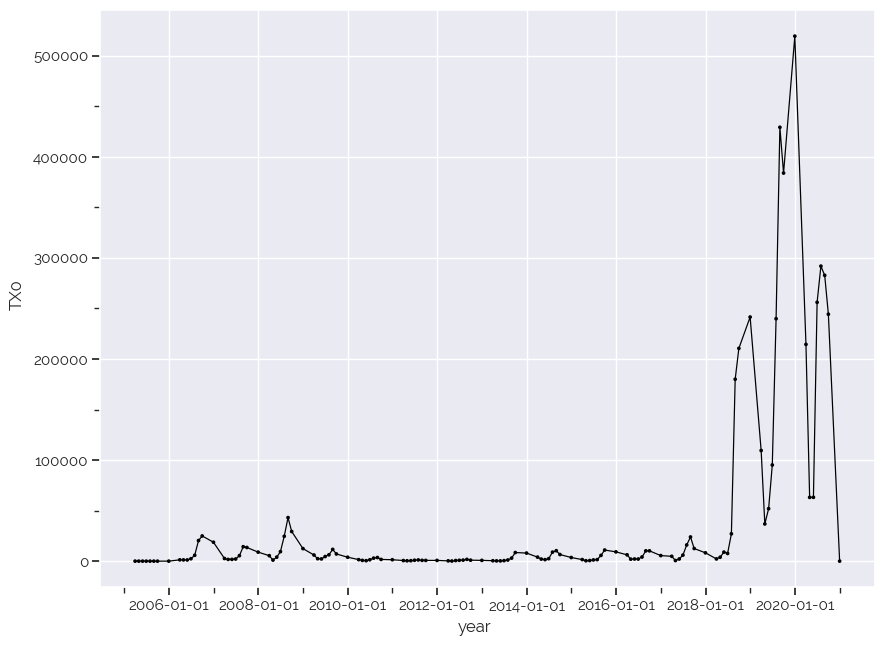

In [79]:
p9.ggplot()
+ p9.geom_col()

# tsfresh

In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor

In [15]:
data.columns

Index(['REVUFBADR', 'Jahr', 'ZR', 'Eigentumsgruppe', 'Zugang', 'Abgang',
       'ETP_mean', 'FF1_mean', 'FF2_mean', 'FFB_mean', 'GRV_mean', 'KWK_mean',
       'KWU_mean', 'RF0_mean', 'RGK_mean', 'RRK_mean', 'RRU_mean', 'SD0_mean',
       'TM0_mean', 'TN0_mean', 'TX0_mean', 'area_nse', 'area_nsne', 'area_se',
       'area_sne', 'centroid_xcoord', 'centroid_ycoord', 'county_name',
       'district_name', 'id', 'timestamp'],
      dtype='object')

In [16]:
data_prep = data.drop(['year', 'fdist_id', 'county_name', 'district_name', 'timeframe', 'forest_ownership'], axis=1).dropna()

In [17]:
df_rolled = roll_time_series(data_prep, column_id="id", column_sort="timestamp",
                             max_timeshift=24, min_timeshift=3)

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\tsfresh\utilities\dataframe_functions.py:454: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
Rolling: 100%|██████████| 38/38 [00:03<00:00, 12.02it/s]


In [ ]:
X = extract_features(df_rolled, 
                     column_id="id", column_sort="timestamp", 
                     impute_function=impute, show_warnings=False)

Feature Extraction:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
X.to_csv('X.csv')

In [ ]:
X_saved = X

In [ ]:
X = X_saved

In [ ]:
X.shape

In [ ]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["id", "last_timestamp"]

In [ ]:
y = data_prep.groupby("id").apply(lambda x: x.set_index("timestamp")["infested_wood"].shift(-1)).T
# TODO: Wo kommen NaNs her? --> Wahrscheinlich der eine Bezirk den es nicht mehr gibt nach 2014
# drop 'Erzgebirgskreis-Schwarzenberg-NSW' and 'SW'
y = y[(y.index.get_level_values('id') != 'Erzgebirgskreis-Schwarzenberg-NSW') & (y.index.get_level_values('id') != 'Erzgebirgskreis-Schwarzenberg-SW')]

In [ ]:
y.head()

In [ ]:
# consistrnecy test
y["2006-07-31"] 

data_prep.loc[data_prep['timestamp'] == "2006-08-31"].head(15)





In [ ]:
y = y.dropna()

In [ ]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [ ]:
X_train = X.loc[(slice(None), slice(None, "2018")), :]
X_test = X.loc[(slice(None), slice("2019", "2020")), :]

y_train = y.sort_index().loc[(slice(None), slice(None, "2018"))]
y_test = y.sort_index().loc[(slice(None), slice("2019", "2020"))]

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_train_selected = select_features(X_train, y_train)

In [ ]:
adas = {ts_id: AdaBoostRegressor() for ts_id in X.index.get_level_values('id').unique()}

for ts_id, ada in adas.items():
    ada.fit(X_train_selected.loc[ts_id], y_train.loc[ts_id])

In [ ]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.concat({
    ts_id: pd.Series(adas[ts_id].predict(X_test_selected.loc[ts_id]), index=X_test_selected.loc[ts_id].index)
    for ts_id in adas.keys()
})
y_pred.index.names = ["id", "last_timestamp"]

In [ ]:
y.unstack("id").iloc[:,:4]

In [ ]:
plt.figure(figsize=(15, 6))
i = 80
y.unstack("id").iloc[:,i:i+1].plot(ax=plt.gca())
y_pred.unstack("id").iloc[:,i:i+1].plot(ax=plt.gca(), legend=None, marker=".")